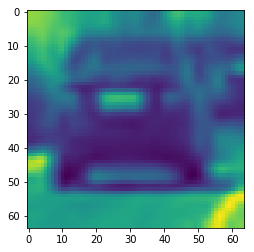

C:\Users\www\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


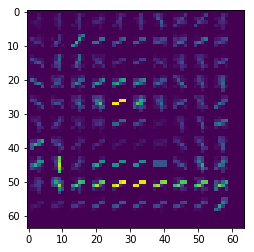

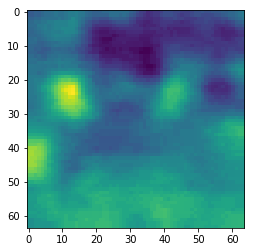

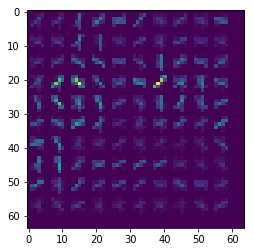

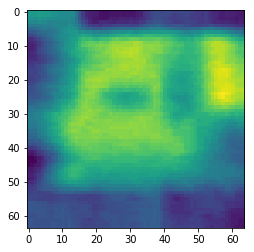

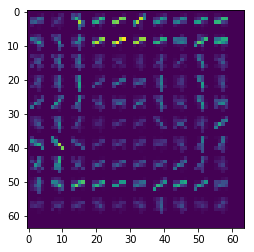

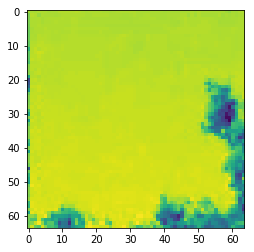

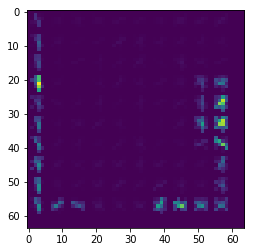

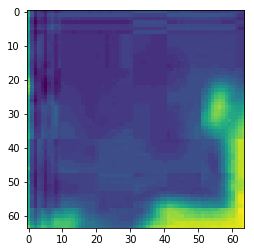

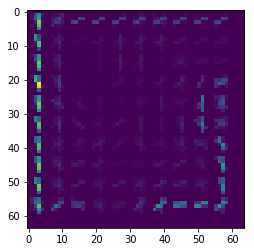

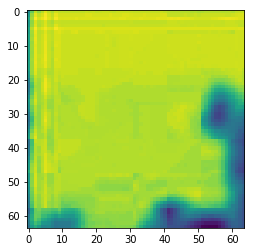

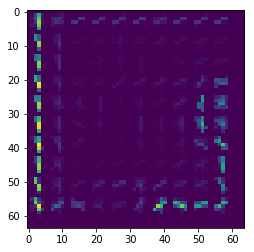

14.55 Seconds to extract HOG features...


In [7]:
#change the sample_size to yield the dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB',spatial_size=(32,32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    count=0
    for file in imgs:
        count=count+1
        if(count%300==0):
            print(count,':')
        img_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
#                 plt.imshow(feature_image[:,:,channel])
#                 plt.show()
                feature,fimage=get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
                hog_features.extend(feature)
#                 plt.imshow(fimage)
#                 plt.show()
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features


# Divide up into cars and notcars
cars = []
notcars = []
images = glob.glob('vehicles/*/*.png')
for image in images:
    cars.append(image)
images = glob.glob('non-vehicles/*/*.png')
for image in images:
    notcars.append(image)

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial = (32, 32) # Spatial binning dimensions
hist_bin = 35    # Number of histogram bins
orient = 9
pix_per_cell = 6
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace,spatial_size=spatial,hist_bins=hist_bin, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace,spatial_size=spatial,hist_bins=hist_bin,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler


In [9]:
print (len(cars),len(notcars))
print (len(car_features),len(notcar_features))
print (np.array(car_features).shape)

8801 8968
8801 8968
(8801, 11925)


In [3]:
#save the dataset
allsave={}
allsave["X"]=X
allsave["hog_channel"]=hog_channel
f1 = open("featuresALL_6_35_YCrCb.p", "wb");
pickle.dump(allsave,f1)


In [1]:
#load the dataset
import pickle
dist_pickle = pickle.load( open("featuresALL_982_32_HLS.p", "rb" ) )
hog_channel=dist_pickle["hog_channel"]
X=dist_pickle["X"]


In [ ]:
#use GridSearchCV to select the most efficient parameter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
import pickle
from sklearn import svm,grid_search
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
# cars = []
# notcars = []
# images = glob.glob('vehicles/*/*.png')
# for image in images:
#     cars.append(image)
# images = glob.glob('non-vehicles/*/*.png')
# for image in images:
#     notcars.append(image)

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time

# sample_size = 500000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
#y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))
y = np.hstack((np.ones(1000), np.zeros(1000)))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
#svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,10],'gamma':[0.1,1,10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
print(clf.best_params_)
#svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

allsave={}
allsave["hog_channel"]=hog_channel
allsave["clf"]=clf.best_params_
f1 = open("clf.p", "wb");
pickle.dump(allsave,f1)


In [4]:
#chage the parameter to do the train and test
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
import pickle
from sklearn import svm,grid_search
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time

# sample_size = 500000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(8801), np.zeros(8968)))
#y = np.hstack((np.ones(1000), np.zeros(1000)))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
#svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc = svm.SVC(kernel='linear',gamma=0.1,C=0.1)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


C:\Users\www\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Feature vector length: 11925
322.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9885
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.
  1.  1.]
For these 20 labels:  [ 0.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.
  1.  1.]
0.41106 Seconds to predict 20 labels with SVC


In [6]:
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
allsave={}
allsave["svc"]=svc
allsave["X_scaler"]=X_scaler
f1 = open("svc_6_35_YCrCb_ALL.p", "wb");
pickle.dump(allsave,f1)


My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.
  1.  1.]
